In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, explained_variance_score, max_error, d2_absolute_error_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from surprise import SVD, Reader, Dataset
from collections import defaultdict
import gzip
from surprise import SVDpp
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import GridSearchCV

### TRAIN DATASET

In [33]:
df_train = pd.read_csv('interactions_train.csv')

In [34]:
df_train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


<Axes: xlabel='rating', ylabel='Count'>

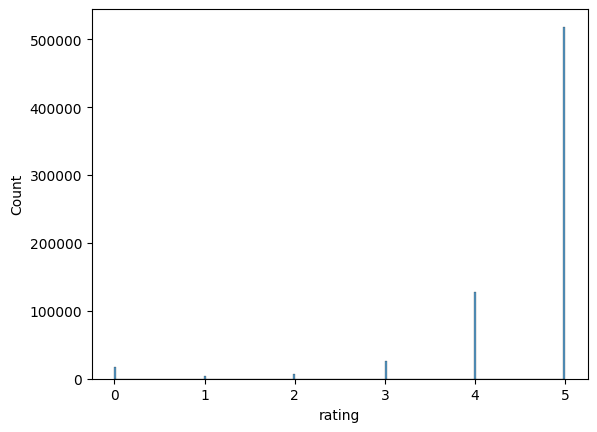

In [35]:
sns.histplot(data=df_train['rating'])

### TEST DATASET

In [36]:
df_test = pd.read_csv('interactions_test.csv')

### CODE

In [37]:
df_train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [38]:
df_test.head()

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935


In [39]:
df_balanced = pd.concat([
    df_train[df_train['rating'] == 5.0].sample(n=25000, random_state=42),  # Sample 50k 5.0 ratings
    df_train[df_train['rating'] == 4.0].sample(n=25000, random_state=42),  
    df_train[(df_train['rating'] != 5.0) & (df_train['rating'] != 4.0)]  # Include all other ratings
])

### FIT THE DATA

In [40]:
reader = Reader(rating_scale=(0, 5))

data = Dataset.load_from_df(df_train[['u', 'i', 'rating']], reader=reader)

trainset = data.build_full_trainset()

### VALIDATE

In [41]:
# Load DataFrame into a Dataset object
reader = Reader(rating_scale=(0, 5))  # Adjust the rating scale as needed
df_valid = pd.read_csv('interactions_validation.csv')
validdata = Dataset.load_from_df(df_valid[['u', 'i', 'rating']], reader)

In [42]:
validset = validdata.build_full_trainset()
validset = validset.build_testset()

In [43]:
algo = SVD(n_factors=100, n_epochs=200, biased=True, lr_all=0.005, reg_all=0.1, verbose=False)
algo.fit(trainset)

# The error of the testing data is calculated and saved
predictions_test = algo.test(validset)
error = accuracy.rmse(predictions_test, verbose = False)
error

1.2773725369573081

In [44]:
cross_validate(algo, validdata, measures=["RMSE", "MAE", "MSE"], cv=5, verbose=True)

Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2799  1.3356  1.3134  1.2980  1.2926  1.3039  0.0192  
MAE (testset)     0.9162  0.9515  0.9325  0.9222  0.9323  0.9309  0.0120  
MSE (testset)     1.6381  1.7838  1.7250  1.6847  1.6709  1.7005  0.0501  
Fit time          0.52    0.54    0.53    0.55    0.55    0.54    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.2798642 , 1.33559594, 1.31338536, 1.29795901, 1.29262418]),
 'test_mae': array([0.91615064, 0.95151502, 0.93249028, 0.92224088, 0.93225376]),
 'test_mse': array([1.63805237, 1.78381652, 1.72498111, 1.6846976 , 1.67087728]),
 'fit_time': (0.5176346302032471,
  0.5352671146392822,
  0.5331270694732666,
  0.5511243343353271,
  0.5533795356750488),
 'test_time': (0.006562709808349609,
  0.00551152229309082,
  0.005042314529418945,
  0.006008625030517578,
  0.00500178337097168)}

### TEST

In [45]:
# Load DataFrame into a Dataset object
reader = Reader(rating_scale=(0, 5))  # Adjust the rating scale as needed
df_test = pd.read_csv('interactions_test.csv')
testdata = Dataset.load_from_df(df_test[['u', 'i', 'rating']], reader)

In [46]:
testset = testdata.build_full_trainset()
testset = testset.build_testset()

In [47]:
# The error of the testing data is calculated and saved
predictions_test = algo.test(testset)
error = accuracy.rmse(predictions_test, verbose = False)
error

1.332020283056521

In [48]:
cross_validate(algo, testdata, measures=["RMSE", "MAE", "MSE"], cv=5, verbose=True)

Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2850  1.3481  1.3549  1.3339  1.3734  1.3391  0.0299  
MAE (testset)     0.9278  0.9600  0.9652  0.9540  0.9807  0.9575  0.0173  
MSE (testset)     1.6512  1.8174  1.8357  1.7793  1.8861  1.7940  0.0792  
Fit time          1.14    1.07    1.06    1.01    1.05    1.06    0.04    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.28500003, 1.34811913, 1.3548914 , 1.33388642, 1.37336021]),
 'test_mae': array([0.9278183 , 0.95998189, 0.96518251, 0.95397927, 0.98073265]),
 'test_mse': array([1.65122508, 1.81742518, 1.8357307 , 1.77925297, 1.88611826]),
 'fit_time': (1.1366357803344727,
  1.0665366649627686,
  1.0551607608795166,
  1.0123207569122314,
  1.0481946468353271),
 'test_time': (0.010577201843261719,
  0.012072563171386719,
  0.010069131851196289,
  0.010068178176879883,
  0.009558916091918945)}

### PRECISION

In [49]:
# Return precision and recall at k metrics for each user
def precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
    return precisions, recalls;

In [50]:
# Returns the precision and recall of the model at k metrics
def get_precision_vs_recall(algo, k_max = 10, verbose = False):
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    if algo:
        for k_curr in range(1, k_max + 1):
            algo.fit(trainset)
            predictions = algo.test(testset)
            
            # Get precision and recall at k metrics for each user
            precisions, recalls = precision_recall_at_k(predictions, k = k_curr, threshold = 4)
            
            # Precision and recall can then be averaged over all users
            precision = sum(prec for prec in precisions.values()) / len(precisions)
            recall = sum(rec for rec in recalls.values()) / len(recalls)
            f1_score = 2 * (precision * recall) / (precision + recall)
            
            # Save measures
            precision_list.append(precision)
            recall_list.append(recall)
            f1_score_list.append(f1_score)
            
            if verbose:
                print('K =', k_curr, '- Precision:', precision, ', Recall:', recall, ', F1 score:', f1_score)
    
    return {'precision': precision_list, 'recall': recall_list, 'f1_score': f1_score_list};

In [51]:
# Calculate the precision and recall of the model at k metrics
k_max = 20
metrics = get_precision_vs_recall(algo, k_max, True)

K = 1 - Precision: 0.8706543556804496 , Recall: 0.9274989963869932 , F1 score: 0.8981781672459862
K = 2 - Precision: 0.8700923323966279 , Recall: 0.9287033319951826 , F1 score: 0.8984429574033025
K = 3 - Precision: 0.8702529104777198 , Recall: 0.9281413087113609 , F1 score: 0.8982654265924764
K = 4 - Precision: 0.8710558008831795 , Recall: 0.927820152549177 , F1 score: 0.8985423642049563
K = 5 - Precision: 0.8709755118426334 , Recall: 0.927739863508631 , F1 score: 0.8984619952097156
K = 6 - Precision: 0.8703331995182657 , Recall: 0.9270172621437174 , F1 score: 0.8977813920877242
K = 7 - Precision: 0.8706543556804496 , Recall: 0.927739863508631 , F1 score: 0.8982910915565512
K = 8 - Precision: 0.8701726214371738 , Recall: 0.9273384183059012 , F1 score: 0.8978465050562227
K = 9 - Precision: 0.8707346447209956 , Recall: 0.9276595744680851 , F1 score: 0.8982961815354599
K = 10 - Precision: 0.8710558008831795 , Recall: 0.9287033319951826 , F1 score: 0.8989563212719252
K = 11 - Precision: 0.

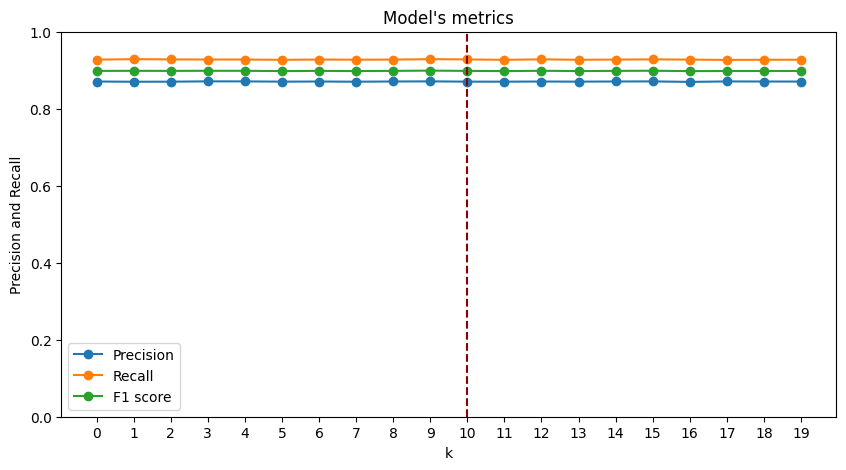

In [52]:
# Get data
c1 = metrics['precision']
c2 = metrics['recall']
c3 = metrics['f1_score']
x = np.arange(len(c1))

# Set up the matplotlib figure
fig, ax1 = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0, 1)
ax1.plot(x, c1, marker = 'o')
ax1.plot(x, c2, marker = 'o')
ax1.plot(x, c3, marker = 'o')
ax1.axvline(x = 10, color = "#8b0000", linestyle = "--")

# Chart setup
plt.title("Model's metrics", fontsize = 12)
plt.xlabel("k", fontsize = 10)
plt.ylabel("Precision and Recall", fontsize = 10)
plt.legend(("Precision", "Recall", "F1 score"), loc = "best")
plt.draw()

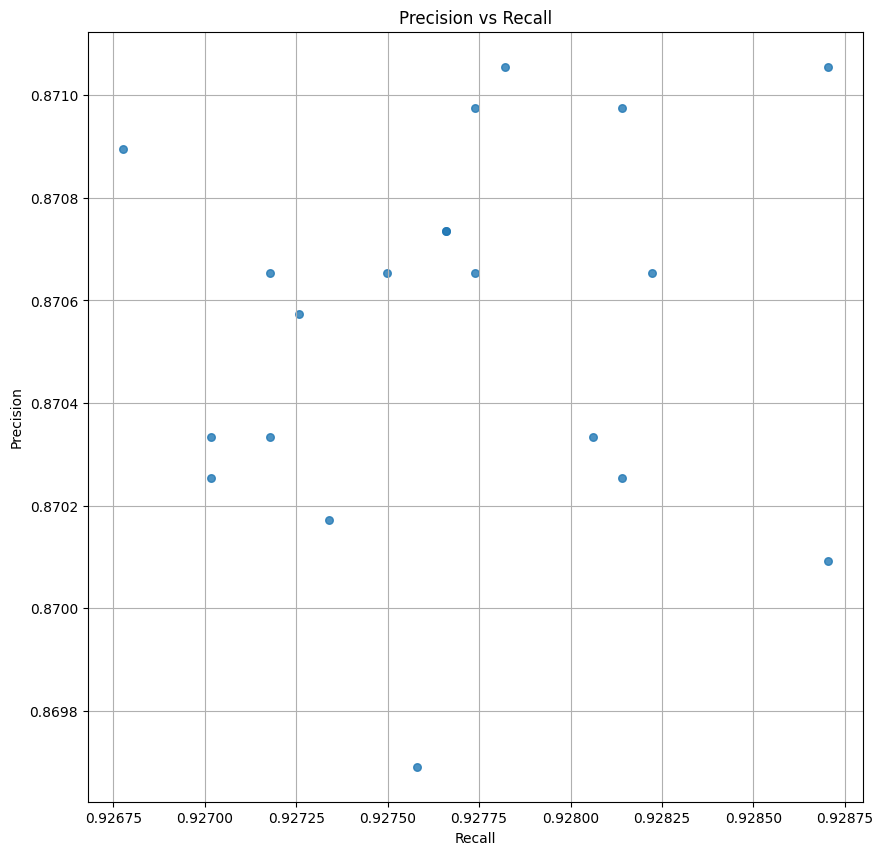

In [53]:
# Get data
x = metrics['recall']
y = metrics['precision']

# Create scatter plot with the precision and recall results
fig, ax2 = plt.subplots(figsize = (10, 10))

# Create 2D scatter plot
sns.regplot(ax = ax2, x = x, y = y, fit_reg = False, marker = "o", color = "#1f77b4", scatter_kws = {"s": 30})

# Plot setup
ax2.set_title("Precision vs Recall", fontsize = 12)
ax2.set_xlabel("Recall", fontsize = 10)
ax2.set_ylabel("Precision", fontsize = 10)
ax2.grid()